## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

## 1. Carga datos y representa la serie

In [2]:
df = pd.read_csv("data/AirPassengers.csv", index_col="date", parse_dates=["date"])
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


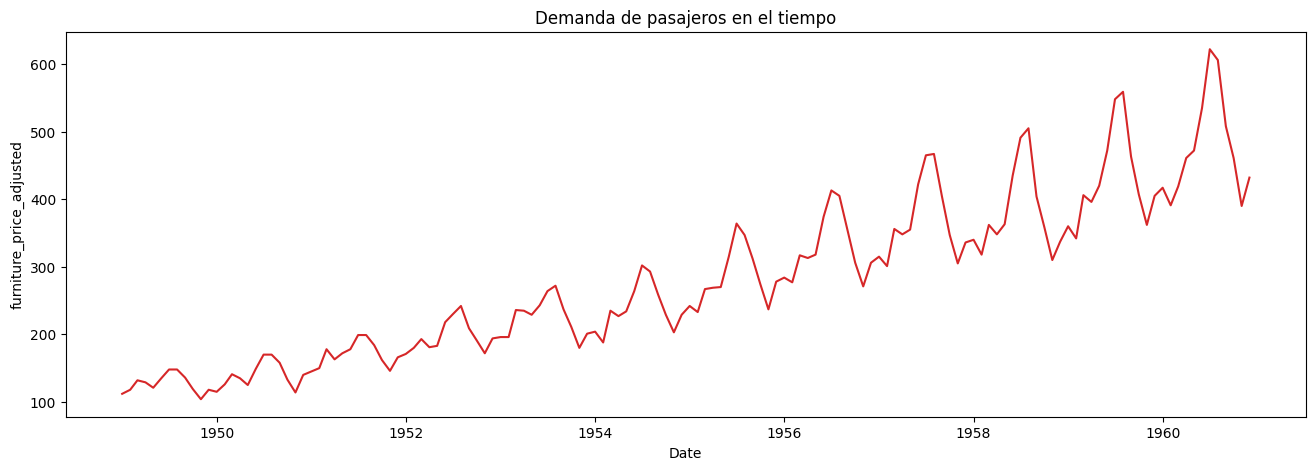

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='furniture_price_adjusted', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df["value"], title='Demanda de pasajeros en el tiempo') 

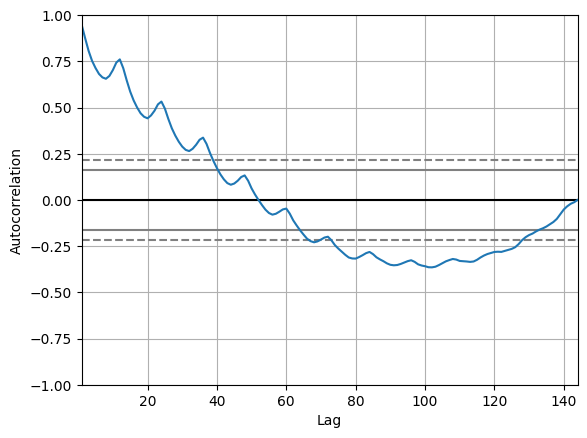

In [5]:
autocorrelation_plot(df["value"].values);

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

In [ ]:
# Es hacer una gráfica con la time series y otra línea con la media

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [6]:
result = adfuller(df['value'].values)
result[1]

0.991880243437641

In [7]:
result = kpss(df['value'].values)
result[1]

/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


0.01

In [8]:
#No es estacionaria

## 4. Aplica una transformación logarítmica

In [9]:
df["value"] = np.log(df["value"])

In [10]:
df.head()

,value
date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


## 5. Divide en train y test. Guarda 20 muestras para test.

In [11]:
train, test = df[0:-20], df[-20:]

In [12]:
print(f"Longitud: {len(train)}")
train.head()

Longitud: 124


,value
date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


In [13]:
print(f"Longitud: {len(test)}")
test.head()

Longitud: 20


,value
date,
1959-05-01,6.040255
1959-06-01,6.156979
1959-07-01,6.306275
1959-08-01,6.326149
1959-09-01,6.137727


## 6. Crea tu primer modelo ARIMA

In [14]:
import itertools
p=d=q=range(0,10)
pdq = list(itertools.product(p,d,q))
results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        results.append((param,model_arima_fit.aic()))
    except:
        continue
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/administrador/.pyenv/versions/3.11.1/lib/python3.

,ARIMA params,AIC
918,"(9, 1, 8)",-344.581665
818,"(8, 1, 8)",-343.251497
919,"(9, 1, 9)",-342.460043
819,"(8, 1, 9)",-340.034394
817,"(8, 1, 7)",-331.251580


In [15]:
model_ar = ARIMA(order=(9,1,8))
model_ar.fit(train)

/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/Users/administrador/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(9, 1, 8))

In [16]:
prediction = model_ar.predict(20)
print(f"MAE: {mean_absolute_error(test, prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(test, prediction))}")

MAE: 0.03397309801509625
RMSE: 0.0432490922380058


## 7. Representa en una gráfica los datos de test y tus predicciones.

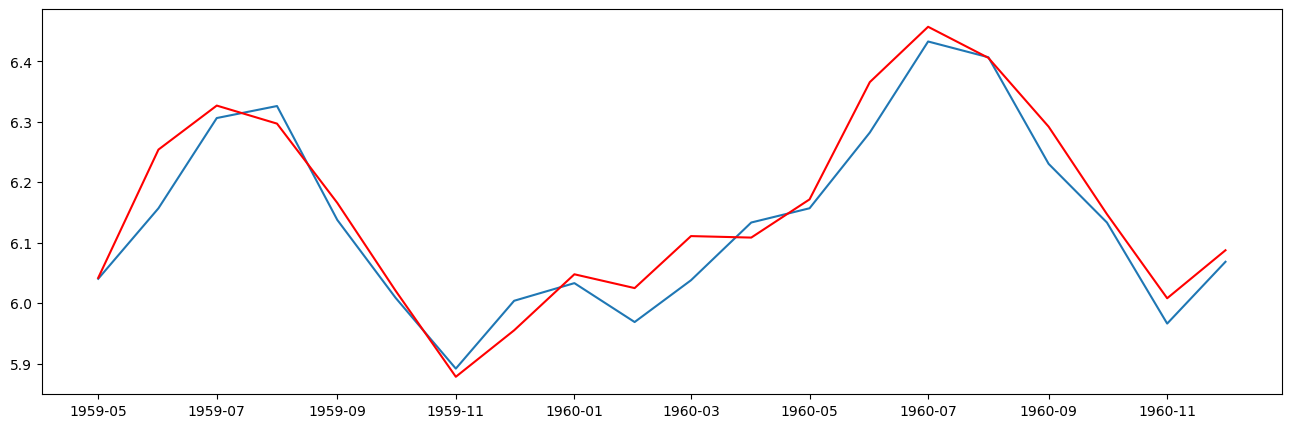

In [17]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(test)
plt.plot(prediction,color='red');

## 8. Prueba otros modelos, a ver qué performance presentan.

In [18]:
df_alternative = df.copy()

for i in range(12,0,-1):
    df_alternative['t-'+str(i)] = df_alternative['value'].shift(i)

df_alternative.dropna(inplace=True)
df_alternative

,value,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1950-01-01,4.744932,4.718499,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685
1950-02-01,4.836282,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932
1950-03-01,4.948760,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282
1950-04-01,4.905275,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760
1950-05-01,4.828314,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760,4.905275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,6.406880,6.326149,6.137727,6.008813,5.891644,6.003887,6.033086,5.968708,6.037871,6.133398,6.156979,6.282267,6.432940
1960-09-01,6.230481,6.137727,6.008813,5.891644,6.003887,6.033086,5.968708,6.037871,6.133398,6.156979,6.282267,6.432940,6.406880
1960-10-01,6.133398,6.008813,5.891644,6.003887,6.033086,5.968708,6.037871,6.133398,6.156979,6.282267,6.432940,6.406880,6.230481


In [19]:
train, test = df_alternative[0:-20], df_alternative[-20:]

In [26]:
dt = DecisionTreeRegressor()
dt.fit(train.drop("value", axis=1), train["value"])
prediction = dt.predict(test.drop("value", axis=1))
print(f"MAE: {mean_absolute_error(test['value'], prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(test['value'], prediction))}")
param_grid = {
    'max_depth': [3, 10],
    'min_samples_split': [2, 3]
}
grid_search = GridSearchCV(dt,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )
grid_search.fit(train.drop("value", axis=1), train["value"])
dt = grid_search.best_estimator_
dt.predict(test.drop("value", axis=1))
print(f"MAE optimiced: {mean_absolute_error(test['value'], prediction)}")
print(f"RMSE optimiced: {np.sqrt(mean_squared_error(test['value'], prediction))}")

MAE: 0.09319910008056671
RMSE: 0.11210070980331878
MAE optimiced: 0.09319910008056671
RMSE optimiced: 0.11210070980331878


In [32]:
rdf = RandomForestRegressor()
rdf.fit(train.drop("value", axis=1), train["value"])
rdf.predict(test.drop("value", axis=1))
print(f"MAE: {mean_absolute_error(test['value'], prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(test['value'], prediction))}")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 10],
    'min_samples_split': [2, 3]
}
grid_search = GridSearchCV(rdf,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )
grid_search.fit(train.drop("value", axis=1), train["value"])
rdf = grid_search.best_estimator_
rdf.predict(test.drop("value", axis=1))
print(f"MAE optimiced: {mean_absolute_error(test['value'], prediction)}")
print(f"RMSE optimiced: {np.sqrt(mean_squared_error(test['value'], prediction))}")

MAE: 0.09319910008056671
RMSE: 0.11210070980331878
MAE optimiced: 0.09319910008056671
RMSE optimiced: 0.11210070980331878
